In [1]:
import sys
import json
from enum import Enum
import time
import os

sys.path.append('../')

In [2]:
class formula:
    def __init__(self, lineage):
        if type(lineage) is dict:
            self.operator = lineage["operator"]
            self.subformula = lineage["subformula"]
        else:
            self.operator = None
            self.subformula = lineage
        for index, element in enumerate(self.subformula):
            if type(element) != str and type(element) != formula:
                subformula = formula(element)
                self.subformula[index] = subformula
        
        self.variables_dict = self.get_variable_dict(self.subformula)
        self.variables = self.get_variables(self.subformula)
        self.variable_count = len(self.variables)

        self.id = None

    def __str__(self):
        string = "{\"operator\": " + str(self.operator) +"," + "\n \"subformula\": ["
        list_of_strings = []
        for element in self.subformula:
            list_of_strings.append(str(element))
        return string + ", ".join(list_of_strings) +"]}"

    def get_variable_dict(self, subformula):
        variables_dict = {}
        for element in subformula:
            if isinstance(element, formula):
                dict_ = element.get_variable_dict(element.subformula)
                for key, value in dict_.items():
                #for key, value in element.variables_dict.items():
                    if key in variables_dict:
                        variables_dict[key] += value
                    else:
                        variables_dict[key] = value
            elif isinstance(element, str) or isinstance(element, int):
                if element in variables_dict:
                    variables_dict[element] += 1
                else:
                    variables_dict[element] = 1
        return variables_dict

    def get_variables(self, subformula):
        variables = set()
        for element in subformula:
            if isinstance(element, formula):
                variables.update(element.get_variable_dict(element.subformula).keys())
            elif isinstance(element, str):
                variables.add(element)
        self.variables = variables
        return variables
    
    def __try_to_find_independent_set(self):
        lineage = self.subformula.copy()
        clause_list_left, clause_list_right = [], []
        left_side_variables = set()
        right_side_variables = set()
        single_variables = []

        for element in lineage:
            if type(element) == str:
                single_variables.append(element)
        
        for element in lineage:
            if type(element) != str:
                if len(left_side_variables) == 0:
                    left_side_variables.update(element.get_variables(element.subformula))
                    clause_list_left.append(element)
                    continue
                if not set(element.variables).isdisjoint(left_side_variables):
                    clause_list_left.append(element)
                    left_side_variables.update(element.get_variables(element.subformula))
                else:
                    clause_list_right.append(element)
                    right_side_variables.update(element.get_variables(element.subformula))

        for variable in single_variables:
            checkSum = 0
            if variable in left_side_variables:
                clause_list_left.append(variable)
                checkSum += 1
            if variable in right_side_variables:
                clause_list_right.append(variable)
                checkSum += 1
            if checkSum == 0:
                clause_list_right.append(variable)
            if checkSum == 2:
                return False, None, None
    
        if len(clause_list_left) == 0 or len(clause_list_right) == 0 or not left_side_variables.isdisjoint(right_side_variables):
            return False, None, None

        if len(clause_list_left) == 1:
            left_formula = clause_list_left[0]
        else:
            left_formula = formula({"operator": self.operator , "subformula": clause_list_left})

        if len(clause_list_right) == 1:
            right_formula = clause_list_right[0]
        else:
            right_formula = formula({"operator": self.operator , "subformula": clause_list_right})

        left_formula = self.reduce_depth(left_formula)
        right_formula = self.reduce_depth(right_formula)

        return True, left_formula, right_formula 
  
    def try_to_find_independent_or(self):
        if self.operator != "or":
            return False, None, None
        return self.__try_to_find_independent_set()
        
    def try_to_find_independent_and(self):
        if self.operator != "and":
            return False, None, None
        return self.__try_to_find_independent_set()
    
    def set_variable_to_true(self, variable_to_remove):
        lineage = self.subformula.copy()

        #first run over all elements and only check variables not subformulas
        for index, element in enumerate(lineage):
            if isinstance(element, str) or isinstance(element, int):
                if element == variable_to_remove:
                    if self.operator == "and":
                        lineage.remove(element)
                        if len(lineage) == 0:
                            return True
                    elif self.operator == "or":
                        return True
            
        #only now run over all elements and only check subformulas
        for index, element in enumerate(lineage):
            if isinstance(element, formula) and variable_to_remove in element.get_variables(element.subformula):
                result = element.set_variable_to_true(variable_to_remove)
                if result == True:
                    lineage.remove(element)
                    if len(lineage) == 0:
                        return True
                else:
                    lineage[index] = result
             
        return formula({"operator": self.operator , "subformula": lineage})

    def set_variable_to_false(self, variable_to_remove):
        lineage = self.subformula.copy()

        #first run over all elements and only check variables not subformulas
        for index, element in enumerate(lineage):
            if isinstance(element, str) or isinstance(element, int):
                if element == variable_to_remove:
                    if self.operator == "and":
                        return False
                    elif self.operator == "or":
                        lineage.remove(element)
                        if len(lineage) == 0:
                            return False

        #only now run over all elements and only check subformulas
        for index, element in enumerate(lineage):
            if isinstance(element, formula) and variable_to_remove in element.get_variables(element.subformula):
                result = element.set_variable_to_false(variable_to_remove)
                if result == False:
                    lineage.remove(element)
                    if len(lineage) == 0:
                        return False
                else:
                    lineage[index] = result
             
        return formula({"operator": self.operator , "subformula": lineage})

    def reduce_depth(self, formula):
        parentOperator = self.operator

        if isinstance(formula, str):
            return formula
        if isinstance(formula, int):
            return formula
        if isinstance(formula, bool):
            return formula
            
        for index, clause in enumerate(formula.subformula):
            try:
                if clause.operator == parentOperator:
                    formula.subformula.pop(index)
                    formula.subformula += clause.subformula
                    formula.reduce_depth(formula.subformula)
                else:
                    formula.subformula[index] = formula.reduce_depth(clause)  

            except:
                continue

        for index, clause in enumerate(formula.subformula):
            try:
                if (isinstance(clause, str) or isinstance(clause, int)) and len(formula.subformula) == 1:
                    return clause
                else:
                    formula.subformula[index] = formula.reduce_depth(clause)
            except:
                continue

        if len(formula.subformula) == 1:
            return formula.subformula[0]

        return formula

    def find_exclusive_or(self):
        var_dict = self.get_variable_dict(self.subformula)
        variable_to_remove = max(var_dict, key=lambda key: var_dict[key])
        
        left_formula = self.set_variable_to_true(variable_to_remove)
        right_formula = self.set_variable_to_false(variable_to_remove)

        #left_formula = self.reduce_depth(left_formula)
        #right_formula = self.reduce_depth(right_formula)
               
        return left_formula, right_formula, variable_to_remove
    
    def satisfying_assignments(self):
        if self.operator == "and":
            result = 1
        
        if self.operator == "or":
            result = 2 ** (self.variable_count) -1

        return result
    
    def satisfying_assignments_fact(self, fact):
        if fact not in self.variables:
            return 0
        
        if self.operator == "and":
            result = 1
        
        if self.operator == "or":
            result = 2 ** (self.variable_count) -1

        return result
    
    def satisfying_assignments_without_fact(self, fact):
        if fact not in self.variables:
            if self.operator == "and":
                return 1
            if self.operator == "or":
                return 2 ** (self.variable_count) -1
        else:
            if self.operator == "and":
                return 0
            if self.operator == "or":
                return 2 ** (self.variable_count) -2 #minus one when all are false and minus one when only facto would be true
        
        return 0

    def critical_assignments_for_fact(self, fact):
        if fact not in self.variables:
            return 0

        satisfied_assignment_with_fact = self.satisfying_assignments_fact(fact)
        satisfied_assignment_without_fact = self.satisfying_assignments_without_fact(fact)

        return satisfied_assignment_with_fact - satisfied_assignment_without_fact

In [3]:
gobal_var_to_id_dict = {}

def assign_id(formula, current_id = 0):
    formula.id = current_id
    current_id += 1

    for subformula in formula.subformula:
        if isinstance(subformula, type(formula)):
            current_id = assign_id(subformula, current_id)
        else:
            if subformula not in gobal_var_to_id_dict:
                gobal_var_to_id_dict[subformula] = {formula.id}
            else:
                gobal_var_to_id_dict[subformula].add(formula.id)

    return current_id

def find_symmetric_variables(gobal_var_to_id_dict):
    symmetric_variables = {}
    for variable, id_set in gobal_var_to_id_dict.items():
        id_tuple = tuple(sorted(id_set))
        if id_tuple in symmetric_variables:
            symmetric_variables[id_tuple].append(variable)
        else:
            symmetric_variables[id_tuple] = [variable]

    symmetric_variables = {key: value for key, value in symmetric_variables.items() if len(value) > 1}
            
    return symmetric_variables.values()

def create_lifted_variable_dict(symmetric_variables):
    lifted_variable_dict = {}
    var_to_lifted_var_dict = {}
    lifted_index = 0
    for variable_tuple in symmetric_variables:
        lifted_variable_dict[lifted_index] = variable_tuple
        lifted_index += 1

    var_to_lifted_var_dict = {}
    for lifted_var, variable_tuple in lifted_variable_dict.items():
        for variable in variable_tuple:
            var_to_lifted_var_dict[variable] = lifted_var

    return lifted_variable_dict, var_to_lifted_var_dict

def assign_id(formula, current_id = 0, gobal_var_to_id_dict = {}):
    formula.id = current_id
    current_id += 1

    for subformula in formula.subformula:
        if isinstance(subformula, type(formula)):
            current_id = assign_id(subformula, current_id, gobal_var_to_id_dict)
        else:
            if subformula not in gobal_var_to_id_dict:
                gobal_var_to_id_dict[subformula] = {formula.id}
            else:
                gobal_var_to_id_dict[subformula].add(formula.id)

    return current_id

def lift_formula(formula):
    gobal_var_to_id_dict = {}
    assign_id(formula, 0, gobal_var_to_id_dict)

    symmetric_variables =  find_symmetric_variables(gobal_var_to_id_dict)
    lifted_variable_dict, var_to_lifted_var_dict = create_lifted_variable_dict(symmetric_variables)
    lift_variables(formula, var_to_lifted_var_dict)
    return lifted_variable_dict, gobal_var_to_id_dict

def lift_variables(formula, var_to_lifted_var_dict):
    for index, subformula in enumerate(formula.subformula):
        if isinstance(subformula, type(formula)):
            lift_variables(subformula, var_to_lifted_var_dict)
        else:
            if subformula in var_to_lifted_var_dict:
                if var_to_lifted_var_dict[subformula] in formula.subformula:
                    formula.subformula.pop(index)
                else:
                    formula.subformula[index] = str(var_to_lifted_var_dict[subformula])

gobal_var_to_clause_dict = {}

def lift_read_once_clause(formula, current_var=0):
    variables_dict = formula.get_variable_dict(formula.subformula)
    variables_to_lift = []
    for subformula in formula.subformula:
        if isinstance(subformula, type(formula)):
            current_var = lift_read_once_clause(subformula, current_var)
        else:
            if variables_dict[subformula] == 1:
                variables_to_lift.append(subformula)
    if len(variables_to_lift) > 1:
        for variable in variables_to_lift:
            formula.subformula.remove(variable)

        formula.subformula.append(str(current_var))
        gobal_var_to_clause_dict[current_var] = {"operator": formula.operator, "subformula": variables_to_lift}
        current_var += 1

    formula.get_variable_dict(formula.subformula)
    return current_var

In [4]:
class DTREE_GATE(Enum):
    Independent_Or = 1
    Independent_And = 2
    Exclusive_Or = 3
    Empty_Gate = 4

class Dtree:
    def __init__(self, dtrees, gate: DTREE_GATE, hidden_variable=None):
        self.formula: formula = None
        self.dtree1: Dtree = None
        self.dtree2: Dtree = None
        self.hidden_variable = hidden_variable

        if gate is None or gate == DTREE_GATE.Empty_Gate:
            is_last_level = True
            try:
                for element in dtrees.subformula:
                    if not isinstance(element, str):
                        is_last_level = False
                        break
            except:
                pass

            if is_last_level:
                self.formula = dtrees
                self.size = 1
                self.gate = DTREE_GATE.Empty_Gate
            else:
                success = False
                if dtrees.operator== "or":
                    self.gate = DTREE_GATE.Independent_Or
                    success, left_formula, right_formula  = dtrees.try_to_find_independent_or()
                    #if success:
                        #print("independet or")
                elif dtrees.operator == "and" or success is False:
                    self.gate = DTREE_GATE.Independent_And
                    success, left_formula, right_formula = dtrees.try_to_find_independent_and()
                    #if success:
                        #print("independet and")
                if success is False:
                    #print("exclusive or")
                    left_formula, right_formula, removed_variable = dtrees.find_exclusive_or()
                    self.gate = DTREE_GATE.Exclusive_Or
                    if self.hidden_variable is None:
                        self.hidden_variable = []
                    if removed_variable is not None:
                        self.hidden_variable.append(removed_variable)
                #if left_formula:
                    #print("left_formula", left_formula)
                    #if not isinstance(left_formula, str) and not isinstance(left_formula, bool):
                        #print(left_formula.variables)
                #if right_formula:
                    #print("right_formula", right_formula)
                    #if not isinstance(right_formula, str) and not isinstance(right_formula, bool):
                        #print(right_formula.variables)
                self.dtree1 = Dtree(left_formula, None)
                self.dtree2 = Dtree(right_formula, None)
                self.size = self.dtree1.size + self.dtree2.size + 1 

        else:
            self.dtree1, self.dtree2 = dtrees
            self.size = self.dtree1.size + self.dtree2.size + 1
            self.gate: DTREE_GATE = gate

        self.variables = self.__get_variables__()
        self.variable_count = len(self.variables)
        self.current_satisfying_assignments = None

    def get_gate_count(self):
        if self.gate == DTREE_GATE.Empty_Gate:
            return 0
        return self.dtree1.get_gate_count() + self.dtree2.get_gate_count() + 1

    def get_length(self):
        if self.gate == DTREE_GATE.Empty_Gate:
            return 1
        return max(self.dtree1.get_length(), self.dtree2.get_length()) + 1

    def __str__(self):
        if isinstance(self.formula, str):
            return self.formula
        else:
            if self.gate == DTREE_GATE.Empty_Gate:
                return str(self.formula)
                
            return str(self.gate) + " " + str(self.dtree1) + " " + str(self.dtree2)


    def get_size(self):
        return self.size

    def __get_variables__(self):
        variables = []
        if self.formula:
            if isinstance(self.formula, str):
                variables.append(self.formula)
            elif isinstance(self.formula, bool):
                return []
            else:
                variables = list(set().union(variables, self.formula.variables))
        if self.dtree1:
            variables = list(set().union(variables, self.dtree1.variables))
        if self.dtree2:
            variables = list(set().union(variables, self.dtree2.variables))
        if self.hidden_variable is not None:
            variables = list(set().union(variables, self.hidden_variable))
        return variables 
                   
    def satisfying_assignments(self):
        if self.current_satisfying_assignments is not None:
            return self.current_satisfying_assignments

        if self.gate is None or self.gate == DTREE_GATE.Empty_Gate:
            if isinstance(self.formula, str):
                return 1
            if isinstance(self.formula, bool):
                if self.formula:
                    return 1
                else:
                    return 0
            else:
                self.current_satisfying_assignments = self.formula.satisfying_assignments()
            return self.current_satisfying_assignments

        dtree1_assignments = self.dtree1.satisfying_assignments()
        dtree2_assignments = self.dtree2.satisfying_assignments()

        if self.gate == DTREE_GATE.Independent_Or:
            return dtree1_assignments * (2 ** self.dtree2.variable_count) + \
                    dtree2_assignments * (2 ** self.dtree1.variable_count) - \
                    dtree1_assignments * dtree2_assignments
            

        elif self.gate == DTREE_GATE.Independent_And:
            return dtree1_assignments * dtree2_assignments
            
        elif self.gate == DTREE_GATE.Exclusive_Or:
            variables1 = self.dtree1.variables
            variables2 = self.dtree2.variables

            unique_variables1 = len([x for x in variables1 if x not in variables2])
            unique_variables2 = len([x for x in variables2 if x not in variables1])

            return dtree1_assignments * (2 ** unique_variables2) + dtree2_assignments * (2 ** unique_variables1)

        else:
            print("Error - false gate")
            raise ValueError("Error - false gate")
            return -1

    def critical_assignments_fact(self, fact):
        if fact not in self.variables:
            return 0

        if self.gate is None or self.gate == DTREE_GATE.Empty_Gate:
            if isinstance(self.formula, str):
                return 1 if self.formula == fact else 0
            return self.formula.critical_assignments_for_fact(fact)

        if self.gate == DTREE_GATE.Independent_Or:
            if fact in self.dtree1.variables:
                return self.dtree1.critical_assignments_fact(fact) * (
                        (2 ** self.dtree2.variable_count) - self.dtree2.satisfying_assignments())
            else:
                return self.dtree2.critical_assignments_fact(fact) * (
                        (2 ** self.dtree1.variable_count) - self.dtree1.satisfying_assignments())

        elif self.gate == DTREE_GATE.Independent_And:
            if fact in self.dtree1.variables:
                return self.dtree1.critical_assignments_fact(fact) * self.dtree2.satisfying_assignments()
            else:
                return self.dtree2.critical_assignments_fact(fact) * self.dtree1.satisfying_assignments()

        elif self.gate == DTREE_GATE.Exclusive_Or:
            variables1 = self.dtree1.variables
            variables2 = self.dtree2.variables
            unique_variables1 = len([x for x in variables1 if x not in variables2])
            unique_variables2 = len([x for x in variables2 if x not in variables1])

            if self.hidden_variable == fact:
                return self.dtree2.satisfying_assignments() * (
                        2 ** unique_variables1) - self.dtree1.satisfying_assignments() * (2 ** unique_variables2)
            else:
                return self.dtree1.critical_assignments_fact(fact) * (
                        2 ** unique_variables2) + self.dtree2.critical_assignments_fact(fact) * (
                            2 ** unique_variables1)

        else:
            print("Error - false gate")
            return -1

In [5]:
with open("data/17b_n_name0_factorised.json") as fp:
    JsonObject = json.load(fp)
lineage = JsonObject[0]  
testFormula = formula(lineage)
lift_read_once_clause(testFormula)
lifted_variable_dict_test, global_var_to_id_dict_test = lift_formula(testFormula)
testFormula.reduce_depth(testFormula)
print(testFormula)

dtree = Dtree(testFormula, None)
print(dtree)

{"operator": and,
 "subformula": [{"operator": or,
 "subformula": [{"operator": and,
 "subformula": [55, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54]}, {"operator": and,
 "subformula": [112, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111]}, {"operator": and,
 "subformula": [152, {"operator": and,
 "subformula": [141, 94e116fa-8738-466a-8712-7d59da3e2d3b]}, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151]}, {"operator": and,
 "subformula": [240, 235, 237, 239, 236, 238]}, {"operator": and,
 "subformula": [297, {"operator": and,
 "subformula": [279, 280]}, {"operator": and,
 "subformula": [281, {"operator": or,
 "subformula": [283, 285, 287, 289, 293, 282, 284, 286, 288, 290, 292, 294, b32a9333-9ff6-4186-aba1-255fb292f437, 291]}]}, {"operator": and,
 "subformula": [295, 296]}]}, {"operator": and,
 "subformula": [363, 346, 347, 348, 349, 350, 351, {"operator": and,
 "subformula": [352, d8d9e884-f059-42

In [6]:
with open("data/17e_n_name17_factorised.json") as fp:
    JsonObject = json.load(fp)
lineage = JsonObject[0]  
testFormula = formula(lineage)
lift_read_once_clause(testFormula)
lifted_variable_dict_test, global_var_to_id_dict_test = lift_formula(testFormula)
testFormula.reduce_depth(testFormula)
print(testFormula)

dtree = Dtree(testFormula, None)
print(dtree)

{"operator": and,
 "subformula": [{"operator": or,
 "subformula": [{"operator": and,
 "subformula": [22, 19, 20, {"operator": and,
 "subformula": [21, 41a288ad-b0ba-47a9-878b-59bfa01b2854]}]}, {"operator": and,
 "subformula": [48, {"operator": and,
 "subformula": [46, e38c9136-46a4-4930-a20c-5f9e75b690db]}, {"operator": and,
 "subformula": [47, 79020ea6-c94a-49fd-92b7-30795981424b]}]}, {"operator": and,
 "subformula": [73, {"operator": and,
 "subformula": [67, d64db579-ddbe-4a55-894b-bb782533e986]}, 68, 69, 70, 71, 72]}, {"operator": and,
 "subformula": [98, 89, 90, {"operator": and,
 "subformula": [91, d64db579-ddbe-4a55-894b-bb782533e986]}, 92, 93, 94, 95, 96, 97]}, {"operator": and,
 "subformula": [111, 110]}, {"operator": and,
 "subformula": [137, {"operator": and,
 "subformula": [128, e1ba7f1d-de9a-46e2-b22a-472b048cd97c]}, {"operator": and,
 "subformula": [129, e4ccbf04-a186-4ded-bd75-74d90efe0170]}, 130, {"operator": and,
 "subformula": [131, e38c9136-46a4-4930-a20c-5f9e75b690db

In [7]:
with open("data/17e_n_name4_factorised.json") as fp:
    JsonObject2 = json.load(fp)
lineage2 = JsonObject2[0]  
testFormula2 = formula(lineage2)
lift_read_once_clause(testFormula2)
lifted_variable_dict_test2, global_var_to_id_dict_test2 = lift_formula(testFormula2)
testFormula.reduce_depth(testFormula2)
print(testFormula2)

dtree2 = Dtree(testFormula2, None)
print(dtree2)

{"operator": and,
 "subformula": [{"operator": or,
 "subformula": [{"operator": and,
 "subformula": [28, {"operator": and,
 "subformula": [22, 93c5bc3e-2e30-4b49-b060-2663b8829cf6]}, {"operator": and,
 "subformula": [23, 384d186d-3333-48d1-8635-20376cc41b5d]}, 24, 25, 26, 27]}, {"operator": and,
 "subformula": [48, {"operator": and,
 "subformula": [46, 93c5bc3e-2e30-4b49-b060-2663b8829cf6]}, {"operator": and,
 "subformula": [47, 60b32243-97b9-4c68-b693-73299de50a81]}]}, {"operator": and,
 "subformula": [76, 70, 71, 72, 73, {"operator": and,
 "subformula": [74, 93c5bc3e-2e30-4b49-b060-2663b8829cf6]}, 75]}, {"operator": and,
 "subformula": [103, 98, 99, {"operator": and,
 "subformula": [100, 384d186d-3333-48d1-8635-20376cc41b5d]}, 101, 102]}, {"operator": and,
 "subformula": [121, 119, {"operator": and,
 "subformula": [120, 8f25954b-281f-462f-a06c-fc3e59e5138b]}]}, {"operator": and,
 "subformula": [140, {"operator": and,
 "subformula": [134, e061784f-2350-4776-9fb3-695b0083b60c]}, {"oper

In [8]:
with open("data/22d_mi_idx_info3_factorised.json") as fp:
    JsonObject3 = json.load(fp)
lineage3 = JsonObject3[0]  
testFormula3 = formula(lineage3)
lift_read_once_clause(testFormula3)
lifted_variable_dict_test3, global_var_to_id_dict_test3 = lift_formula(testFormula3)
testFormula.reduce_depth(testFormula3)
print(testFormula3)

dtree3 = Dtree(testFormula3, None)
print(dtree3)

{"operator": and,
 "subformula": [c9e737b1-8388-47a6-808f-13bbfaac7531, {"operator": or,
 "subformula": [95e9518e-b209-4637-887e-a6d631520fbd, {"operator": or,
 "subformula": [{"operator": and,
 "subformula": [7de5036b-dedf-4b94-8861-ed0f86e0e553, {"operator": and,
 "subformula": [3b822ae2-2199-45e4-8313-6788b5607574, {"operator": or,
 "subformula": [24, {"operator": or,
 "subformula": [0, 1, 2]}, 3, {"operator": or,
 "subformula": [14, 15, 16, 17, 18, 19]}, 20, 23, 13, 4, 5, 6, 7, 8, 9, 10, 11, 12, 22, 21]}]}, {"operator": and,
 "subformula": [7554c5fc-971b-48cf-83b1-236a3e37a02e, {"operator": or,
 "subformula": [38, {"operator": or,
 "subformula": [25, 26, 27]}, 28, 36, 37, 39, 35, 29, 30, 31, 32, 33, 34]}]}, {"operator": and,
 "subformula": [fc1aa9ec-ec01-41d7-b612-ce9212f58163, {"operator": or,
 "subformula": [64, {"operator": or,
 "subformula": [40, 41, 42]}, 43, {"operator": or,
 "subformula": [54, 55, 56, 57, 58, 59]}, 60, 63, 53, 44, 45, 46, 47, 48, 49, 50, 51, 52, 62, 61]}]}]}

In [9]:
def calculate_banzhaf2(dtree, timeout=3600):
    if dtree.variable_count == 0:
        return {"status": "Success", "expansion_time": 0, "calculation_time": 0, "depth": 0, "banzhaf_values": {}}
    banzhaf_vals = {}
    start = time.time()
    for fact in dtree.variables:
        banzhaf_vals[fact] = dtree.critical_assignments_fact(fact)
        mid = time.time()
        if mid - start > timeout:
            return {"status": "Failed", "calculation_time": "Failed", "banzhaf_values": banzhaf_vals}
    end = time.time()
    calc_time = end - start
    return {"status": "Success","calculation_time": calc_time, "banzhaf_values": banzhaf_vals}

In [10]:
result = calculate_banzhaf2(dtree, 3600)
print(result)

{'status': 'Success', 'calculation_time': 0.008998632431030273, 'banzhaf_values': {'d64db579-ddbe-4a55-894b-bb782533e986': -3843424158, '25': 3858466914, '57': 3858466914, '41a288ad-b0ba-47a9-878b-59bfa01b2854': 0, '62': 3858466914, '17': 3858466914, '141': 3858466914, '131': -58482, '99': 3858466914, '9395e4ea-41a1-4bda-8749-1e5d56af41fa': 0, '143': 3858466914, '55': 3858466914, '35': 3858466914, '13': 3858466914, '59': 3858466914, '81': 3858466914, '80': 3858466914, '71': 3858466914, '132': -575586, '9': 3858466914, '66': 3858466914, '111': 3858466914, '79020ea6-c94a-49fd-92b7-30795981424b': 0, '18': 3858466914, '110': 3858466914, '19': 3858466914, '3': 3858466914, '29': 3858466914, '22': 3858466914, '130': -575586, '104': 3858466914, '49': 3858466914, '15': 3858466914, '47': -327717738, '88': 3858466914, '140': 3858466914, '31': 3858466914, '20': 3858466914, '127': 3858466914, '69': 3858466914, '103': 3858466914, '72': 3858466914, '112': 3858466914, '76': 3858466914, '93': -7521378,

In [11]:
result2 = calculate_banzhaf2(dtree2, 3600)
print(result2)

{'status': 'Success', 'calculation_time': 0.02299785614013672, 'banzhaf_values': {'74': -315966881883870, '25': -315966881883870, '57': -315966881883870, '162': 21064458792258, '62': -315966881883870, '17': -315966881883870, '181': -315966881883870, '195': -2487928203810, '187': -315966881883870, '246': -315966881883870, '131': -315966881883870, '166': -315966881883870, '99': -10192480060770, '241': -315966881883870, '234': -315966881883870, '242': -315966881883870, '143': -315966881883870, '272': -315966881883870, '55': -315966881883870, '243': -315966881883870, '199': -2487928203810, '279': -315966881883870, '269': 105322293961290, '271': -315966881883870, '186': -315966881883870, '35': -315966881883870, '344ea546-9f57-48b5-9ecc-f2b8c799fd8e': 0, '59': -315966881883870, '244': -105322293961290, '13': -315966881883870, '163': -315966881883870, '80': 21064458792258, '71': -315966881883870, '171': -315966881883870, '192': -315966881883870, '9': -315966881883870, '173': -315966881883870,

In [12]:
result3 = calculate_banzhaf2(dtree3, 3600)
print(result3)

{'status': 'Success', 'calculation_time': 9.668542385101318, 'banzhaf_values': {'589': 0, '482': 2164637499760906877833570128821525097689054383303980838218493117361583082083010996384802746545161735064580597481472000, '495': 2164637499760906877833570128821525097689054383303980838218493117361583082083010996384802746545161735064580597481472000, '755': -2999650772511676188238926549999628404396722029995383401189891359399670798383827215756181408779693662422193715710094932012141571374974403744625094174836897494922690560, '7554c5fc-971b-48cf-83b1-236a3e37a02e': -309901575494634262002494575951460568592488118602597912005037772167736763653674987417169334501761371534755554800330033699225600, '561': 430830553681289211028610994097546960468019216770882176345107066375329804474474862721597874411744079783376738173583360000, '369': 4329275498050626536684766828118855026208135278173381303033739971766521742589311624411290889219771813339891222183936000, '99': 2164637499760906877833570128821525097689054383303

In [38]:
def get_gate_lengths(dtree, length=0, dtree_length_list=[]):
    if dtree.gate != DTREE_GATE.Empty_Gate:
        length += 1
        get_gate_lengths(dtree.dtree1, length, dtree_length_list)
        get_gate_lengths(dtree.dtree2, length, dtree_length_list)
    else:
        dtree_length_list.append(length)
    return dtree_length_list

In [92]:
directory = os.fsencode("data")
dtreeList = []
dtree_length_list_list = []
dtree_gate_count_list = []

i=0
for file in os.listdir(directory):
    filename = os.fsdecode(file)

    if filename == "old" or filename == "hardFactorisedFormulas.zip" or filename == "example":
        continue

    i=i+1
    print(filename + " " + str(i))

    with open("data/" + filename) as fp:
        JsonObject = json.load(fp)
    lineage = JsonObject[0]
    testFormula = formula(lineage)
    lift_read_once_clause(testFormula)
    lifted_variable_dict_test, global_var_to_id_dict_test = lift_formula(testFormula)
    testFormula.reduce_depth(testFormula)
    dtree = Dtree(testFormula, None)
    dtree_length_list = get_gate_lengths(dtree, 0, [])
    dtree_length_list_list.append(dtree_length_list)
    dtree_gate_count_list.append(dtree.get_gate_count())

    dtreeList.append(dtree)

17b_n_name0_factorised.json 1
17b_n_name1_factorised.json 2
17d_n_name0_factorised.json 3
17e_n_name0_factorised.json 4
17e_n_name10_factorised.json 5
17e_n_name11_factorised.json 6
17e_n_name12_factorised.json 7
17e_n_name13_factorised.json 8
17e_n_name14_factorised.json 9
17e_n_name15_factorised.json 10
17e_n_name16_factorised.json 11
17e_n_name17_factorised.json 12
17e_n_name1_factorised.json 13
17e_n_name2_factorised.json 14
17e_n_name3_factorised.json 15
17e_n_name4_factorised.json 16
17e_n_name5_factorised.json 17
17e_n_name6_factorised.json 18
17e_n_name7_factorised.json 19
17e_n_name8_factorised.json 20
17e_n_name9_factorised.json 21
22d_mi_idx_info0_factorised.json 22
22d_mi_idx_info1_factorised.json 23
22d_mi_idx_info2_factorised.json 24
22d_mi_idx_info3_factorised.json 25
8d_an1_name0_factorised.json 26
8d_an1_name10_factorised.json 27
8d_an1_name11_factorised.json 28
8d_an1_name12_factorised.json 29
8d_an1_name13_factorised.json 30
8d_an1_name14_factorised.json 31
8d_an1_na

In [36]:
dtree_length_list

[4,
 6,
 7,
 8,
 9,
 10,
 10,
 6,
 6,
 4,
 5,
 5,
 4,
 4,
 4,
 6,
 7,
 9,
 10,
 12,
 12,
 13,
 13,
 12,
 10,
 10,
 11,
 11,
 10,
 7,
 8,
 8,
 8,
 9,
 10,
 10,
 8,
 10,
 10,
 11,
 12,
 14,
 14,
 13,
 12,
 13,
 15,
 15,
 14,
 13,
 15,
 15,
 16,
 16,
 15,
 14,
 15,
 16,
 16,
 14,
 15,
 17,
 18,
 20,
 20,
 19,
 19,
 19,
 20,
 20,
 19,
 18,
 21,
 21,
 22,
 22,
 21,
 20,
 21,
 22,
 24,
 24,
 23,
 1]

In [ ]:
dtreeList
dtree_length_list_list
dtree_gate_count_list

In [43]:
import matplotlib.pyplot as plt

In [75]:
len(dtree_length_list_list[11])

30

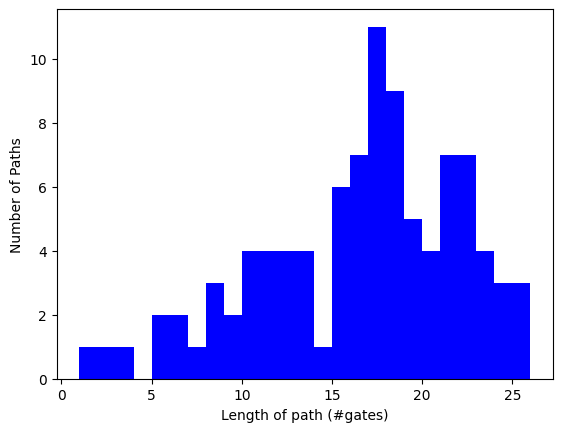

In [127]:
values_list = dtree_length_list_list[18]
fig = plt.figure()
plt.hist(values_list, bins= int(max(values_list))-1,color='b')
plt.xlabel('Length of path (#gates)')
plt.ylabel('Number of Paths')
plt.show()
fig.savefig('pathLengthExampleDtree.png', dpi=fig.dpi)

In [94]:
dtreeList[22].get_length()

35

In [104]:
dtree_length_list = []
for dtree in dtreeList:
    dtree_length_list.append(dtree.get_length())

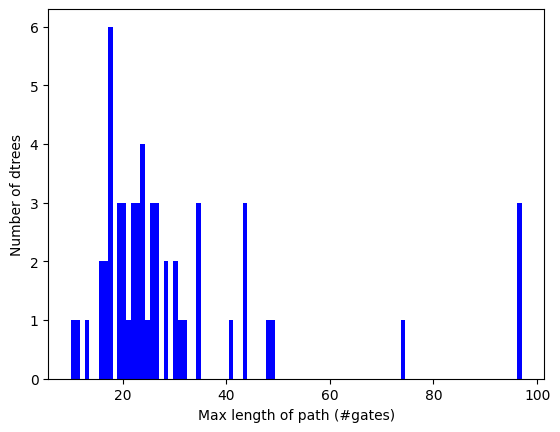

In [108]:
values_list = dtree_length_list
fig = plt.figure()
plt.hist(values_list, bins= int(max(values_list)),color='b')
plt.xlabel('Max length of path (#gates)')
plt.ylabel('Number of dtrees')
plt.show()
fig.savefig('maxLengthDtrees.png', dpi=fig.dpi)